M5 Forecasting - Accuracy

Note: This is one of the two complementary competitions that together comprise the M5 forecasting challenge. Can you estimate, as precisely as possible, the point forecasts of the unit sales of various products sold in the USA by Walmart?

How much camping gear will one store sell each month in a year? To the uninitiated, calculating sales at this level may seem as difficult as predicting the weather. Both types of forecasting rely on science and historical data. While a wrong weather forecast may result in you carrying around an umbrella on a sunny day, inaccurate business forecasts could result in actual or opportunity losses. In this competition, in addition to traditional forecasting methods you’re also challenged to use machine learning to improve forecast accuracy.

The Makridakis Open Forecasting Center (MOFC) at the University of Nicosia conducts cutting-edge forecasting research and provides business forecast training. It helps companies achieve accurate predictions, estimate the levels of uncertainty, avoiding costly mistakes, and apply best forecasting practices. The MOFC is well known for its Makridakis Competitions, the first of which ran in the 1980s.

In this competition, the fifth iteration, you will use hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.

If successful, your work will continue to advance the theory and practice of forecasting. The methods used can be applied in various business areas, such as setting up appropriate inventory or service levels. Through its business support and training, the MOFC will help distribute the tools and knowledge so others can achieve more accurate and better calibrated forecasts, reduce waste and be able to appreciate uncertainty and its risk implications.

Evaluation:
This competition uses a Weighted Root Mean Squared Scaled Error (RMSSE). Extensive details about the metric, scaling, and weighting can be found in the [M5 Participants Guide](https://mofc.unic.ac.cy/m5-competition/).

It is important to notice that this notebook must be seen together with the notebooks "M5 Forecasting - Accuracy Data study.ipynb" and "M5 Forecasting - Accuracy  - Variables". All the necessary data verification, the calculation of the parameters of the ARIMA(p, i, q), and the construction of the variables are done in those two notebook. This notebook have the correlations between variables, the ARIMA model with exogenous variables, and the forecast.

In [1]:
import gc
import time
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima_model import ARIMA

In [2]:
path = 'C:\\Users\\maxwi\\Python\\Kaggle\\M5 Forecasting - Accuracy\\Modelo 1\\model\\data_by_id\\'
path_holdout = 'C:\\Users\\maxwi\\Python\\Kaggle\\M5 Forecasting - Accuracy\\Modelo 1\\model\\holdout_by_id\\'
path_summary = 'C:\\Users\\maxwi\\Python\\Kaggle\\M5 Forecasting - Accuracy\\Modelo 1\\model\\summary_by_id\\'

In [3]:
#Root Mean Squared Scaled Error (RMSSE)
def RMSSE(train, actual, forecast, h = 28):
    sum_1 = 0
    for i in range(len(actual)):
        sum_1 += (actual.iloc[i] - forecast[i])**2
        
    sum_2 = 0
    for i in range(1, len(train)):
        sum_2 += (train.iloc[i] - train.iloc[i - 1])**2
        
    rmsse = round(np.sqrt((1/h)*(sum_1/sum_2)), 4)
    return rmsse

In [4]:
sales_train_validation = pd.read_csv('sales_train_validation.csv') #Only used to take the products ids.
products_ids = sales_train_validation['id'].unique()
products_ids_size = len(products_ids)
del sales_train_validation

In [5]:
#Define all variables that can be used

file_name = products_ids[0:1] #used to get the name of some columns.
variables_aux = pd.read_hdf(path + file_name[0] + '.h5') 


#Time variables:
time_variables = ['season_1', 'season_2', 'season_4'
                 , 'month_fase_1', 'month_fase_3'
                 , 'week_fase_1', 'week_fase_3'
                 , 'month_1', 'month_2', 'month_3', 'month_4', 'month_6', 'month_7'
                 , 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'
                 , 'wday_1', 'wday_2', 'wday_3', 'wday_4', 'wday_6', 'wday_7']

#Holiday variables:
holidays_variables = ["SuperBowl", 'ValentinesDay', 'PresidentsDay', 'LentStart', 'LentWeek2',
       'StPatricksDay', 'Purim End', 'OrthodoxEaster', 'Pesach End',
       'Cinco De Mayo', "Mother's day", 'MemorialDay', 'NBAFinalsStart',
       'NBAFinalsEnd', "Father's day", 'IndependenceDay', 'Ramadan starts',
       'Eid al-Fitr', 'LaborDay', 'ColumbusDay', 'Halloween', 'EidAlAdha',
       'VeteransDay', 'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter', 'Sporting',
       'Cultural', 'National', 'Religious']
holidays_variables_2 = [col for col in variables_aux.columns if col.endswith("_near") or col.endswith("_week") or col.endswith("_weekend")]
for e in holidays_variables_2:
    holidays_variables.append(e)
    
#Demand variables:
demand_variables = ['demand_rolling_std_t7', 'demand_rolling_std_t30', 'demand_rolling_std_t90'
                    , 'demand_rolling_std_t180', 'demand_rolling_std_t365', 'demand_rolling_skew_t30'
                    , 'demand_rolling_kurt_t30']    

#Price variables:
price_variables = [col for col in variables_aux.columns if 'price' in col][1:]

#Snap variables:
snap_variables = ['snap', 'snap_other', 'snap_only_other']

#All variables:
variables_all = []
for e in time_variables:
    variables_all.append(e)
for e in holidays_variables:
    variables_all.append(e)
for e in demand_variables:
    variables_all.append(e)
for e in price_variables:
    variables_all.append(e)
for e in snap_variables:
    variables_all.append(e)
    
#ARIMA parameters:
variables_all.append('p_parameter')
variables_all.append('i_parameter')
variables_all.append('q_parameter')


#Considering that it is impossible to analyse each individual model, we will do a table to resume the result of each model.
columns_variables_all = ['product']
for e in variables_all:
    columns_variables_all.append(e)
columns_variables_all.append('number_of_observation_train')
columns_variables_all.append('number_of_observation_forecast')

columns_variables_all.append('sum_train')
columns_variables_all.append('sum_forecast')

columns_variables_all.append('mean_train')
columns_variables_all.append('mean_test')

columns_variables_all.append('std_train')
columns_variables_all.append('std_test')

columns_variables_all.append('AIC')
columns_variables_all.append('error_fit')

First, we will calculate the correlation between the categories of the variables and the demand. We will keep only the categories with a correlation higher than 0.05. After, we will calculate the correlation between variables and, for each pair with a correlation higher than 0.5, we will keep only the categorie with the higher correlation with the demand.\
We could have done this step without the variables being categorized, but this would imply that we would need to categorize every variable everytime we open a file to model (we would need to categorize the same variable more than 30.000 times!). Therefore, we decided to use the variables already categorized in this step. Nonetheles, the weakness of this strategy is that we may have some categories of one variable and some other categories from another variable. Considering that we will drop categories with a correlation higher than 0.5, this will not imply in any statistical error.

In [6]:
#Filter variables by correlation
'''Verify the correlation between variables:

Time variables:
    season_1, season_2, season_4
    month_fase_1, month_fase_3
    week_fase_1, week_fase_3
    month_1, month_2, month_3, month_4, month_6, month_7, month_8, month_9, month_10, month_11, month_12
    wday_1, wday_2, wday_3, wday_4, wday_6, wday_7

Holiday variables:
It can be identified in the database looking for columns that end with "_near", "_week", or "_weekend" 
Plus the variables:
    'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart', 'LentWeek2',
    'StPatricksDay', 'Purim End', 'OrthodoxEaster', 'Pesach End',
    'Cinco De Mayo', 'Mother's day', 'MemorialDay', 'NBAFinalsStart',
    'NBAFinalsEnd', 'Father's day', 'IndependenceDay', 'Ramadan starts',
    'Eid al-Fitr', 'LaborDay', 'ColumbusDay', 'Halloween', 'EidAlAdha',
    'VeteransDay', 'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
    'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter', 'Sporting',
    'Cultural', 'National', 'Religious'

Demand variables:
    demand_rolling_std_t7, demand_rolling_std_t30, demand_rolling_std_t90,
    demand_rolling_std_t180, demand_rolling_std_t365, demand_rolling_skew_t30, demand_rolling_kurt_t30

Price variables:
It can be identified in the database looking for columns tha with "price" in the name. 
The first column name is droped because we will no use the "sell_price" variable.

Snap variables:
    snap, snap_other, snap_only_other
'''

def get_redundant_pairs(df):
        '''Get diagonal and lower triangular pairs of correlation matrix'''
        pairs_to_drop = set()
        cols = df.columns
        for i in range(0, df.shape[1]):
            for j in range(0, i+1):
                pairs_to_drop.add((cols[i], cols[j]))
        return pairs_to_drop
    
    
def variable_correlation(df, variables, n):
    
    variables.append('demand')
    df = df[variables]
    corr_matrix = df.corr()
    sorted_corrs = corr_matrix['demand'].abs().sort_values(ascending = False)
    #delete variables with correlation lower than 0.05
    variables_to_keep = sorted_corrs[sorted_corrs > 0.05].index
    
 
    corr_table =  df[variables_to_keep].corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df[variables_to_keep])
    corr_table = corr_table.drop(labels = labels_to_drop).sort_values(ascending = False)
    variables_to_drop = []
    for e in corr_table[corr_table > 0.5].index:
        variables_to_drop.append(sorted_corrs[sorted_corrs == min(sorted_corrs[e[0]],sorted_corrs[e[1]])].index[0])
    
    variables_to_keep = variables_to_keep.drop(variables_to_drop)

    return variables_to_keep[1:]

In [7]:
#Suppres some recorrent warnings
import warnings
warnings.filterwarnings("ignore")

Supressed warnings:

C:\Users\maxwi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\maxwi\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  
 C:\Users\maxwi\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available

In [8]:
'''Main code
First: variables selection using correlation.
Second: ARIMA(p, i, q) model
Third: Forecast
Fourth: holdout construction
Last: summary construction
'''
stoped_at = 'FOODS_1_207_CA_3_validation'  #  Used to continue the code from the last product saved. For safety, we will run the last product saved again.
last_product = 'FOODS_2_074_CA_3_validation'
stoped_at_index = np.where(products_ids == stoped_at)[0][0]
last_product_index = np.where(products_ids == last_product)[0][0]
products_ids_size =  last_product_index - stoped_at_index + 1

progress = 0  #Usefull to see the progress of the code. 
progress_100 = 1
start = time.time()

for product in products_ids[stoped_at_index : last_product_index + 1]:
    data_variables = pd.read_hdf(path + product + '.h5')
    data_variables['demand'] = data_variables['demand'].astype('float64') #needed to use statsmodels.tsa.arima_model
    data_variables[variables_all] = data_variables[variables_all].astype('float64') #needed to use statsmodels.tsa.arima_model
    data_variables.reset_index(inplace= True)
     
    data_variables.fillna(data_variables[np.in1d(data_variables['part'], 'train')].mean(), inplace = True)
    data_train = data_variables[np.in1d(data_variables['part'], 'train')]
    data_test_1_2 =  data_variables[(np.in1d(data_variables['part'], 'test1')) | (np.in1d(data_variables['part'], 'test2'))]
    
    columns_to_keep = ['demand']
    
    #Select variables:
    #Time variables:
    variables_to_keep_time = variable_correlation(data_train, time_variables.copy(), 30)
    for e in variables_to_keep_time.values:
        columns_to_keep.append(e)
    
    #Holiday variables:
    variables_to_keep_holidays = variable_correlation(data_train, holidays_variables.copy(), 30)
    for e in variables_to_keep_holidays.values:
        columns_to_keep.append(e)
    
    #Demand variables:
    variables_to_keep_demand = variable_correlation(data_train, demand_variables.copy(), 30)
    for e in variables_to_keep_demand.values:
        columns_to_keep.append(e)
    
    #Price variables:
    variables_to_keep_price = variable_correlation(data_train, price_variables.copy(), 30)
    for e in variables_to_keep_price.values:
        columns_to_keep.append(e)

        
    #Snap variables:
    variables_to_keep_snap = variable_correlation(data_train, snap_variables.copy(), 30)
    for e in variables_to_keep_snap.values:
        columns_to_keep.append(e)
    
    #Parameter for the ARIMA(p, i, q) model
    p_parameter = int(data_variables['p_parameter'].iloc[0])
    i_parameter = int(data_variables['i_parameter'].iloc[0])
    q_parameter = int(data_variables['q_parameter'].iloc[0])
    
    
    #ARIMA(p, i, q) model  
    demand_original = data_train['demand'].copy()
    demand = data_train['demand'].copy() #If necessary, the values of this demand will be differenciated
    variables_exogenous = data_train[columns_to_keep[1:]].copy()
                                                                            
    if i_parameter == 1:
        demand = demand.diff(periods = 1)[1:]
        variables_exogenous = variables_exogenous[1:]
    # fit model
    if len(variables_exogenous) > 0:
        model = ARIMA(demand, order = (p_parameter, i_parameter, q_parameter), exog = variables_exogenous)
    else:
        model = ARIMA(demand, order = (p_parameter, i_parameter, q_parameter))

    #Set start parameters to 0 when statsmodel cannot fit the model alone.  
    try:
        model_fit = model.fit(trend = 'nc')   
        error_fit = 0
    except:
        params = np.zeros(0 + int(p_parameter) + int(q_parameter) + len(columns_to_keep[1:])) #The 0 is because trend = 'nc'. If trend = 'c', change to 1. 
        model_fit = model.fit(start_params = params, trend = 'nc')
        error_fit = 1

#     print(model_fit.summary())      

    #Delete any variable with p-value > 0.1
    try:    #Sometimes statsmodels cannot calculate the p-values.
        variables_2 = model_fit.pvalues[0:len(columns_to_keep[1:])][model_fit.pvalues < 0.1].index
        if len(variables_2) > 0:
            model = ARIMA(demand, order = (p_parameter, i_parameter, q_parameter), exog = variables_exogenous[variables_2])
        else:
            model = ARIMA(demand, order = (p_parameter, i_parameter, q_parameter))
        try:
            model_fit = model.fit(trend = 'nc')      
            error_fit = 0
        except:
            params = np.zeros(0 + int(p_parameter) + int(q_parameter) + len(variables_2)) #The 0 is because trend = 'nc'. If trend = 'c', change to 1. 
            model_fit = model.fit(start_params = params, trend = 'nc')
            error_fit = 1
    except:
        variables_2 = columns_to_keep[1:]
           
#     print(model_fit.summary())      
    
    
    #Forecast
    if len(variables_2) > 0:
        forecast = model_fit.forecast(steps = 56, exog = data_test_1_2[variables_2])[0]
    else:
        forecast = model_fit.forecast(steps = 56)[0]
  
    forecast_2 = []
    for f in forecast:
        if f < 0:
            forecast_2.append(0)
        else:
            forecast_2.append(int(round(f,0)))

    #Make holdout
    holdout_1 = {} #Forecast to the public leaderboard
    holdout_1['id'] = product
    for i in range(28):
        holdout_1['F_' + str(i + 1)] = forecast_2[i]
    holdout_1 = pd.DataFrame([holdout_1])
    
    holdout_2 = {} #Forecast to the private leaderboard
    holdout_2['id'] = f"{product[0:-10]}evaluation"
    for i in range(28):
        holdout_2['F_' + str(i + 1)] = forecast_2[i + 28]
    holdout_2 = pd.DataFrame([holdout_2])

    holdout = pd.concat([holdout_1, holdout_2], ignore_index = True)
    holdout.to_hdf(path_holdout + product + '.h5', key = product, mode = 'w')
    
    #Summary   
    #Create a dictionary with the variables
    summary_product = {}
    for e in columns_variables_all:
        summary_product[e] = 0
    #Mark used variables
    for e in variables_2:
        summary_product[e] = 1
    
    summary_product['product'] = product
    
    summary_product['number_of_observation_train'] = len(data_train)
    summary_product['number_of_observation_forecast'] = len(forecast_2)
    
    summary_product['sum_train'] = sum(demand_original)
    summary_product['sum_forecast'] = sum(forecast_2)
    
    summary_product['mean_train'] = np.mean(demand_original)
    summary_product['mean_test'] = np.mean(forecast_2)
    
    summary_product['std_train'] = np.std(demand_original)
    summary_product['std_test'] = np.std(forecast_2)
    
    summary_product['AIC'] = model_fit.aic
    summary_product['error_fit'] = error_fit
    
    summary_product_df = pd.DataFrame([summary_product])
    summary_product_df.to_hdf(path_summary + product + '.h5', key = product, mode = 'w')
    
    
    progress += 1
    if progress == progress_100 * 100:

        progress_per = round(progress / products_ids_size, 4)
        print(progress_per)
        progress_100 +=1
        
        end = time.time()
        elapsed = int(round(end - start, 0))
        total_run_time =  int(round(elapsed / (progress_per), 0))
        time_to_finish = int(round(elapsed / (progress_per), 0)) - elapsed
        print('Elapsed: {:02d}:{:02d}:{:02d}'.format(elapsed // 3600, (elapsed % 3600 // 60), elapsed % 60))
        print('Total run time: {:02d}:{:02d}:{:02d}'.format(total_run_time // 3600, (total_run_time % 3600 // 60), total_run_time % 60))
        print('Time to finish: {:02d}:{:02d}:{:02d}'.format(time_to_finish // 3600, (time_to_finish % 3600 // 60), time_to_finish % 60))
        print()
        
print()
print("OK!")


OK!


After running this model, we had five products with error.
These products had a model ARIMA(0, 0, 0) with 0 exogenous variables.
Considering that it is only five products, we will model them one by one.\
First, we will analyse the demand to see if there are any visible trends.\
Second, we will study the autocorrelation and the partial autocorrelation to verify if the p and q parameters are really zero.\
Last, we will see tha correlation between the demand and our variables.

Products with error:\
index:  10276\
HOUSEHOLD_2_033_CA_4_validation

index:  10539\
HOUSEHOLD_2_297_CA_4_validation

index:  12677\
HOBBIES_2_066_TX_1_validation

index:  13173\
HOUSEHOLD_1_422_TX_1_validation

index:  9259\
product: HOBBIES_1_117_CA_4_validation

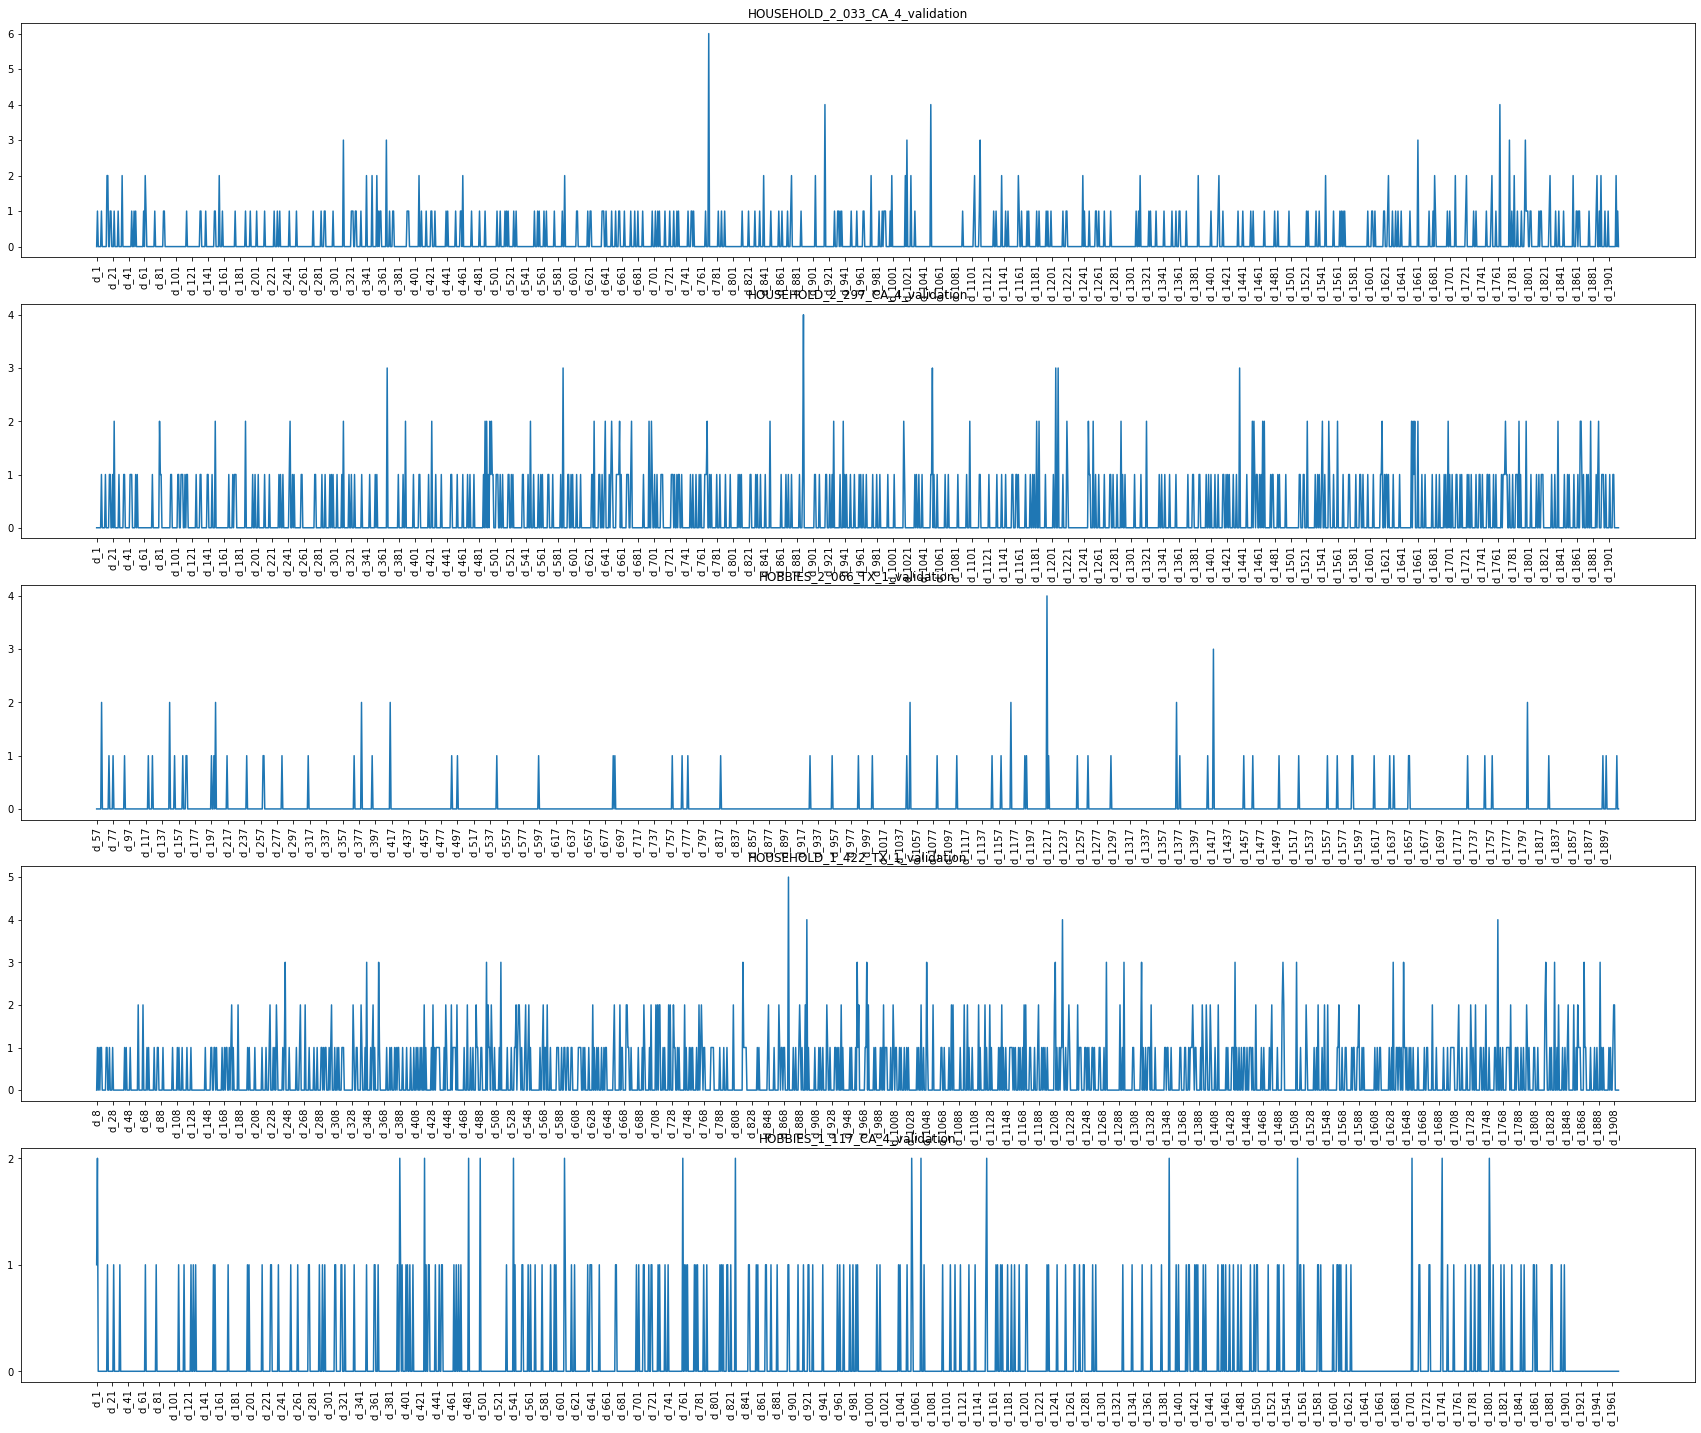

In [194]:
#Demand graph.
data_10276 = pd.read_hdf(path + 'HOUSEHOLD_2_033_CA_4_validation' + '.h5')
data_10539 = pd.read_hdf(path + 'HOUSEHOLD_2_297_CA_4_validation' + '.h5')
data_12677 = pd.read_hdf(path + 'HOBBIES_2_066_TX_1_validation' + '.h5')
data_13173 = pd.read_hdf(path + 'HOUSEHOLD_1_422_TX_1_validation' + '.h5')
data_9259 = pd.read_hdf(path + 'HOBBIES_1_117_CA_4_validation' + '.h5')

data_10276_train = data_10276[np.in1d(data_10276['part'], 'train')]
data_10539_train = data_10539[np.in1d(data_10539['part'], 'train')]
data_12677_train = data_12677[np.in1d(data_12677['part'], 'train')]
data_13173_train = data_13173[np.in1d(data_13173['part'], 'train')]
data_9259_train = data_9259[np.in1d(data_9259['part'], 'train')]

fig = plt.figure('demand', figsize=(30, 25))
# fig.set_title('Demand')
ax1 = fig.add_subplot(5,1,1)
ax2 = fig.add_subplot(5,1,2)
ax3 = fig.add_subplot(5,1,3)
ax4 = fig.add_subplot(5,1,4)
ax5 = fig.add_subplot(5,1,5)

ax1.set_title('HOUSEHOLD_2_033_CA_4_validation')
ax2.set_title('HOUSEHOLD_2_297_CA_4_validation')
ax3.set_title('HOBBIES_2_066_TX_1_validation')
ax4.set_title('HOUSEHOLD_1_422_TX_1_validation')
ax5.set_title('HOBBIES_1_117_CA_4_validation')

ax1.plot(data_10276_train['day'], data_10276_train['demand'])
ax2.plot(data_10539_train['day'], data_10539_train['demand'])
ax3.plot(data_12677_train['day'], data_12677_train['demand'])
ax4.plot(data_13173_train['day'], data_13173_train['demand'])
ax5.plot(data_9259['day'], data_9259['demand'])

for ax in fig.axes:
    plt.sca(ax)
    ax.set_xticks(ax.get_xticks()[::20])
    plt.xticks(rotation = 90)
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

As we can see, the demand of these products does not vary much in range. Thus, at the worst case scenario, we can forecast the demand of the next 56 days as being equal to the mode.

In [195]:
#Partial autocorrelation
# For each product, we will study the autocorretalion and the partial autocorrelation of the demand and the lagged demand. 
#This will catch any error in the ADF test. 
def pacf_acf(data, product):
    with plt.rc_context():
        plt.rc("figure", figsize=(20,10))
        plot_pacf(data['demand'], ax=None, lags=100, alpha=0.01, method= 'ldb', use_vlines=True, title='Partial autocorrelation: ' + product, zero=True)
        plot_pacf(data['demand'].diff(periods = 1)[1:], ax=None, lags=100, alpha=0.01, method= 'ldb', use_vlines=True, title='Partial autocorrelation: ' + product + '(Lagged)', zero=True)

    with plt.rc_context():
        plt.rc("figure", figsize=(20,10))
        plot_acf(data['demand'], ax=None, lags=100, alpha=0.01, use_vlines=True, title='Autocorrelation: ' + product, zero=True)
        plot_acf(data['demand'].diff(periods = 1)[1:], ax=None, lags=100, alpha=0.01, use_vlines=True, title='Autocorrelation: ' + product + '(Lagged)', zero=True) 

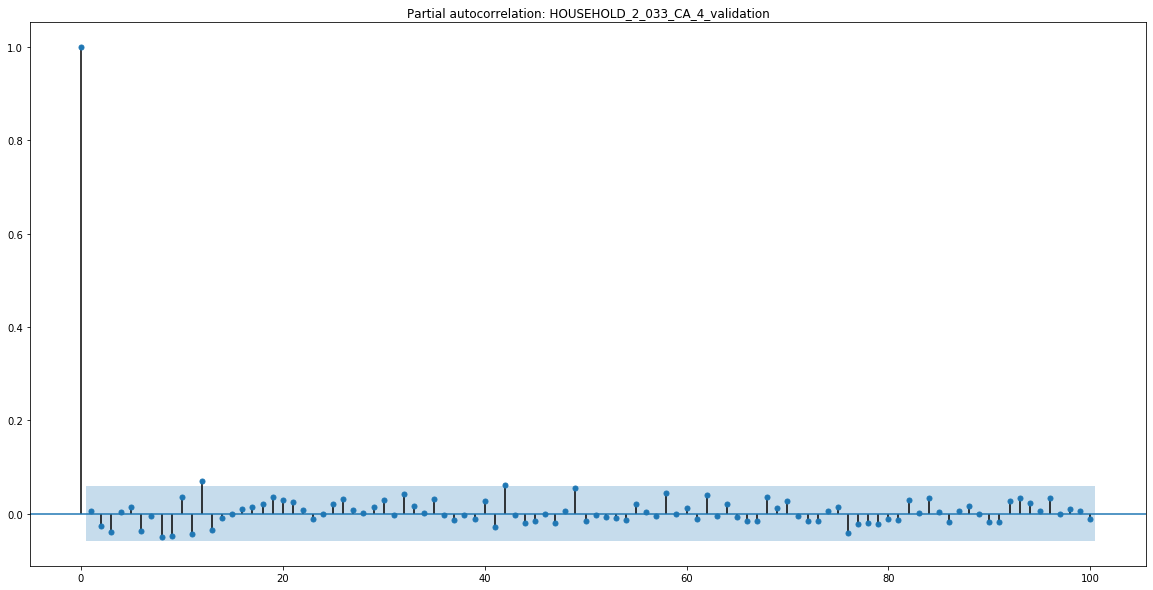

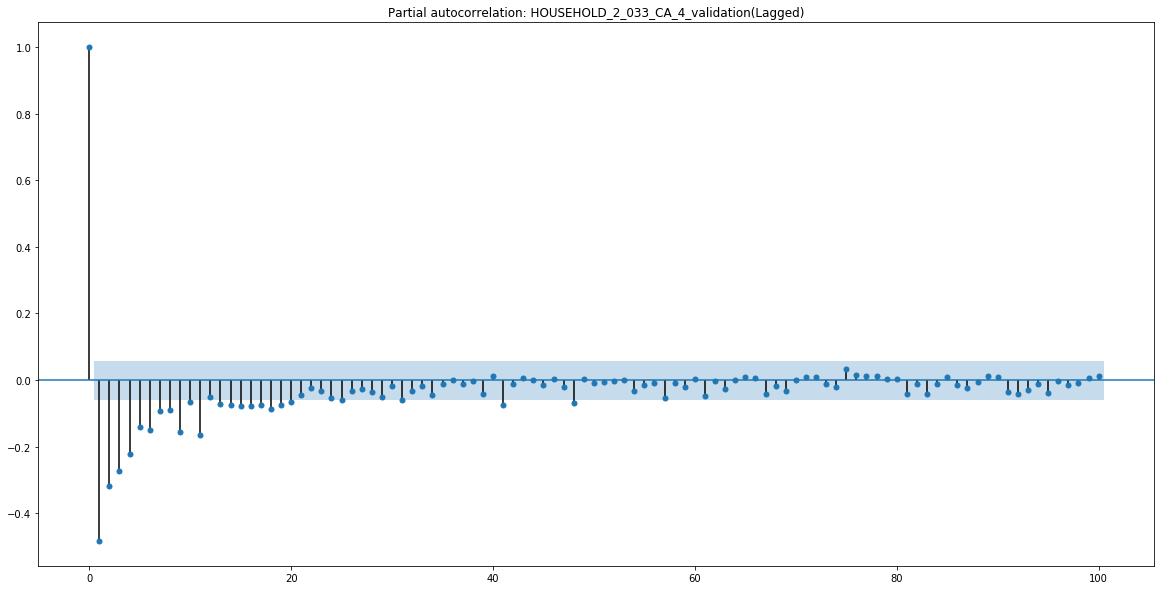

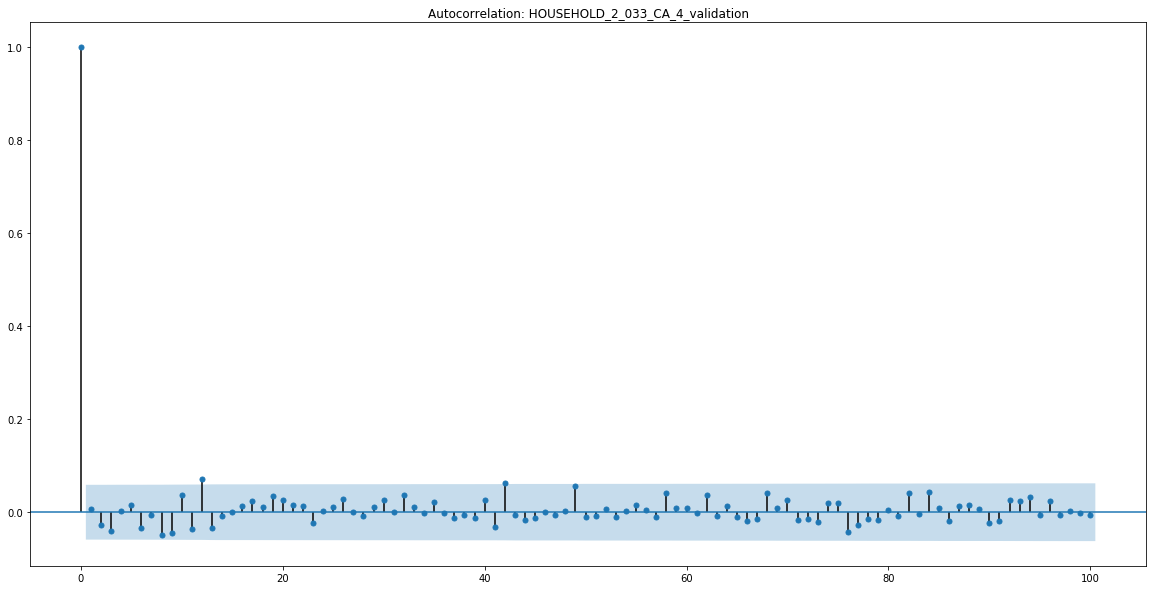

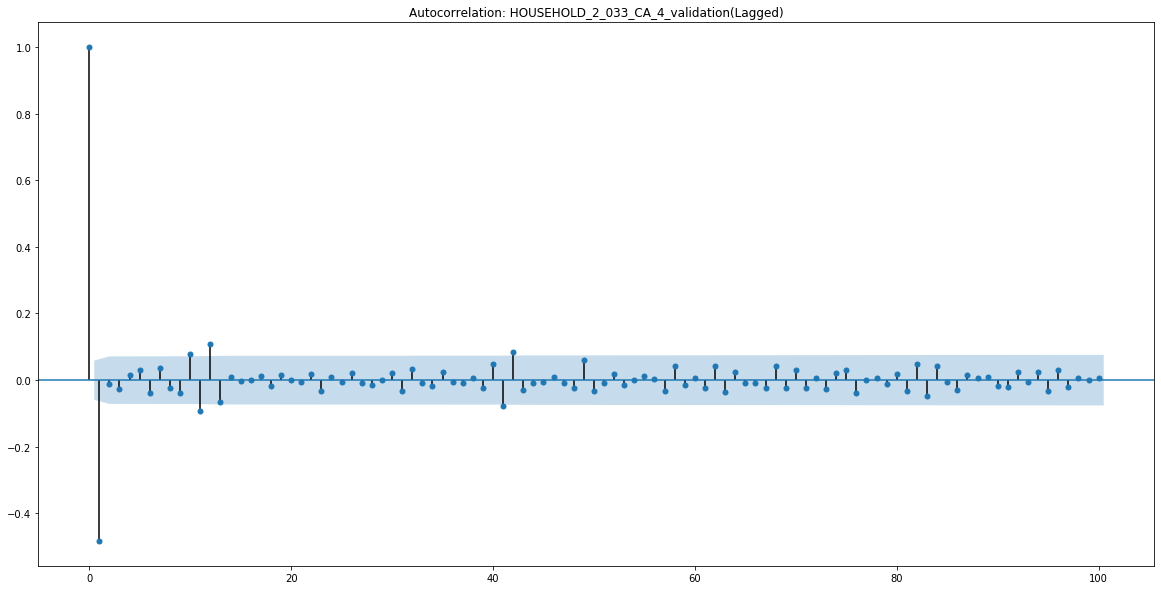

In [196]:
pacf_acf(data_10276_train, 'HOUSEHOLD_2_033_CA_4_validation')

As we can see, the parameters p = 0, i = 0, and q = 0 are not wrong. However, we can also try to model an ARIMA(20, 1, 1) or ARIMA(11, 1, 1).

Lets now see the correlation between the demand and the orher variables.

In [204]:
#Study the correlation between the demand and the exogenous variables.
def correlation_variables(data):
    correlation_variables = []
    for e in time_variables:
        correlation_variables.append(e)
    for e in holidays_variables:
        correlation_variables.append(e)
    for e in demand_variables:
        correlation_variables.append(e)
    for e in price_variables:
        correlation_variables.append(e)
    for e in snap_variables:
        correlation_variables.append(e)

    corr_matrix = data[correlation_variables].corr()
    sorted_corrs = corr_matrix['demand'].abs().sort_values(ascending = False)
    return sorted_corrs

In [205]:
correlation_variables(data_10276_train)

demand                                 1.000000
wday_3                                 0.045352
EidAlAdha_near                         0.044001
ValentinesDay_near                     0.042584
EidAlAdha                              0.042503
                                         ...   
price_change_mean_t52_bin_-0.10-0.5         NaN
price_change_mean_t52_bin_-0.05-0           NaN
price_change_mean_t52_bin_0.05-0.10         NaN
price_change_mean_t52_bin_0.10-0.25         NaN
price_change_mean_t52_bin_0.25++            NaN
Name: demand, Length: 238, dtype: float64

We can observe that none of our variables are correlated with the demand./
Therefore, lets try to model using the mode, ARIMA(20, 1, 2) or ARIMA(11, 1, 2).

Considering that we will compare differents models, we will need to separate our train again in train and test./
After we choose the most appropriate model, we will run our model again in the whole train database and forecast to the holdout. 

In [237]:
#Models for HOUSEHOLD_2_033_CA_4_validation

def model_mode(data):
    train = data.iloc[0:len(data) - 28]['demand']
    test = data.iloc[len(data) - 28:]['demand']
    
    mode = train.mode()[0]
    forecast = np.empty(28) 
    forecast.fill(mode)
    RMSSE_mode = RMSSE(train, test, forecast, h = 28)
    print('Mode:')
    print('Forecast: ', forecast_2)
    return RMSSE_mode

def model_ARIMA(data, p_parameter, i_parameter, q_parameter):
    train = data.iloc[0:len(data) - 28]['demand']
    test = data.iloc[len(data) - 28:]['demand']
    model = ARIMA(train, order = (p_parameter, i_parameter, q_parameter))
    try:
        model_fit = model.fit(trend = 'nc')   
        error_fit = 0
    except:
        params = np.zeros(0 + int(p_parameter) + int(q_parameter)) #The 0 is because trend = 'nc'. If trend = 'c', change to 1. 
        model_fit = model.fit(start_params = params, trend = 'nc')
        error_fit = 1

    forecast = model_fit.forecast(steps = 28)[0]
    forecast_2 = []
    for f in forecast:
        if f < 0:
            forecast_2.append(0)
        else:
            forecast_2.append(int(round(f,0)))

    RMSSE_ARIMA = RMSSE(train, test, forecast_2, h = 28)

    print(model_fit.summary())
    print('ARIMA(' + str(p_parameter) + ', ' +str(i_parameter) + ', ' + str(q_parameter) + ')')
    print('Forecast: ', forecast_2)
    
    return error_fit, RMSSE_ARIMA

In [238]:
#Models for HOUSEHOLD_2_033_CA_4_validation
#Model 1: mode
RMSSE_mode_10276 = model_mode(data_10276_train)

#Model 2: ARIMA(20, 1, 1)
error_fit_2_10276, RMSSE_2_10276 = model_ARIMA(data_10276_train, 20, 1, 1)

Mode:
Forecast:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                 1884
Model:                ARIMA(20, 1, 1)   Log Likelihood               -1328.066
Method:                       css-mle   S.D. of innovations              0.489
Date:                Sat, 16 May 2020   AIC                           2700.132
Time:                        21:38:22   BIC                           2822.037
Sample:                             1   HQIC                          2745.028
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.D.demand      0.0072      0.024      0.302      0.762      -0.040       0.054
ar.L2.D.demand

In [239]:
#Model 3: ARIMA(11, 1, 1)
error_fit_3_10276, RMSSE_3_10276 = model_ARIMA(data_10276_train, 11, 1, 1)

                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                 1884
Model:                ARIMA(11, 1, 1)   Log Likelihood               -1336.395
Method:                       css-mle   S.D. of innovations              0.491
Date:                Sat, 16 May 2020   AIC                           2698.789
Time:                        21:38:56   BIC                           2770.824
Sample:                             1   HQIC                          2725.319
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.D.demand     -0.0014      0.024     -0.059      0.953      -0.048       0.045
ar.L2.D.demand     -0.0419      0.024     -1.769      0.077      -0.088       0.005
ar.L3.D.demand     -0.0529      

In [240]:
#Verify RMSSE
print('RMSSE_mode_10276:', RMSSE_mode_10276)
print('RMSSE_2_10276:', RMSSE_2_10276)
print('RMSSE_3_10276:', RMSSE_3_10276)

RMSSE_mode_10276: 0.025
RMSSE_2_10276: 0.025
RMSSE_3_10276: 0.025


Unfortunately, all 3 models resulted in the same forecast.\
Hence, we will use the mode because it is simpler.

In [241]:
#Make holdout
def holdout_mode(product, data):
    mode = data['demand'].mode()[0]
    forecast = np.empty(56) 
    forecast.fill(mode)
    
    holdout_1 = {} #Forecast to the public leaderboard
    holdout_1['id'] = product
    for i in range(28):
        holdout_1['F_' + str(i + 1)] = forecast[i]
    holdout_1 = pd.DataFrame([holdout_1])

    holdout_2 = {} #Forecast to the private leaderboard
    holdout_2['id'] = f"{product[0:-10]}evaluation"
    for i in range(28):
        holdout_2['F_' + str(i + 1)] = forecast[i + 28]
    holdout_2 = pd.DataFrame([holdout_2])
    holdout = pd.concat([holdout_1, holdout_2], ignore_index = True)
    holdout.to_hdf(path_holdout + product + '.h5', key = product, mode = 'w')
    
    #Summary  
    summary_product = {}
    for e in columns_variables_all:
            summary_product[e] = 0
    summary_product['product'] = product

    summary_product['number_of_observation_train'] = len(data)
    summary_product['number_of_observation_forecast'] = len(forecast)

    summary_product['sum_train'] = sum(data['demand'])
    summary_product['sum_forecast'] = sum(forecast)

    summary_product['mean_train'] = np.mean(data['demand'])
    summary_product['mean_test'] = np.mean(forecast)

    summary_product['std_train'] = np.std(data['demand'])
    summary_product['std_test'] = np.std(forecast)

    summary_product['AIC'] = 0
    summary_product['error_fit'] = 1

    summary_product_df = pd.DataFrame([summary_product])
    summary_product_df.to_hdf(path_summary + product + '.h5', key = product, mode = 'w')

In [272]:
#Make holdout
holdout_mode('HOUSEHOLD_2_033_CA_4_validation', data_10276_train)

Lets study our next product:\
HOUSEHOLD_2_297_CA_4_validation

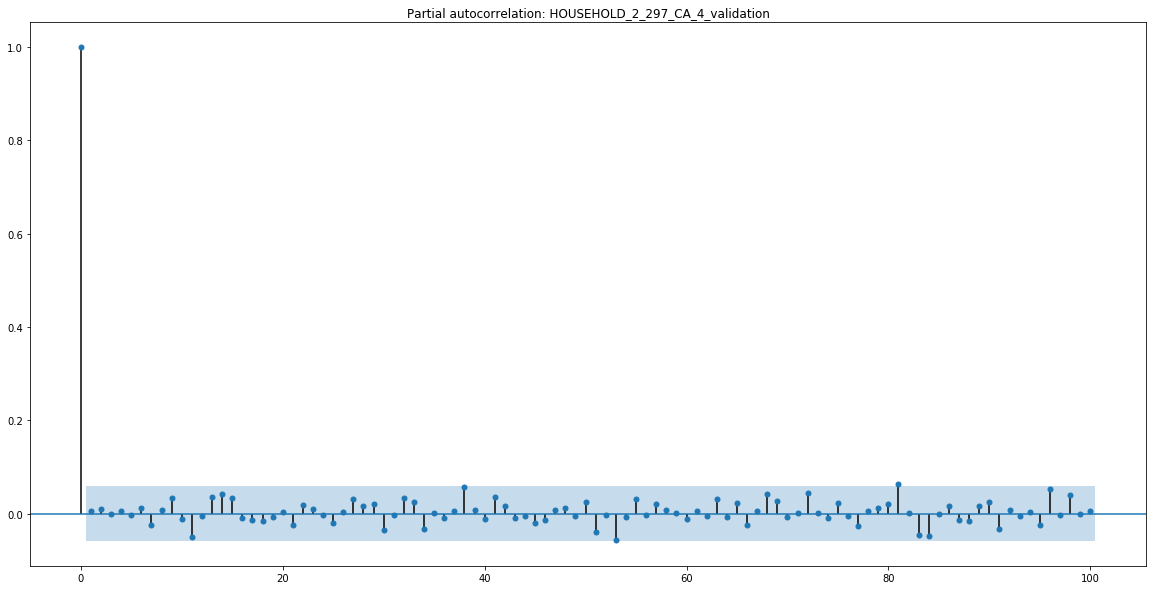

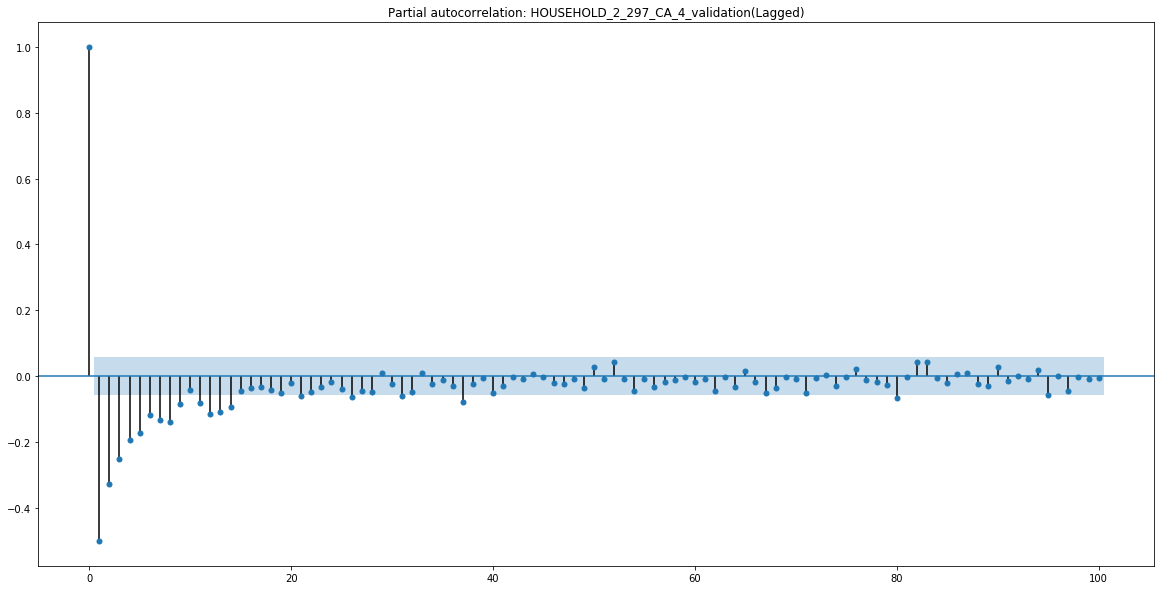

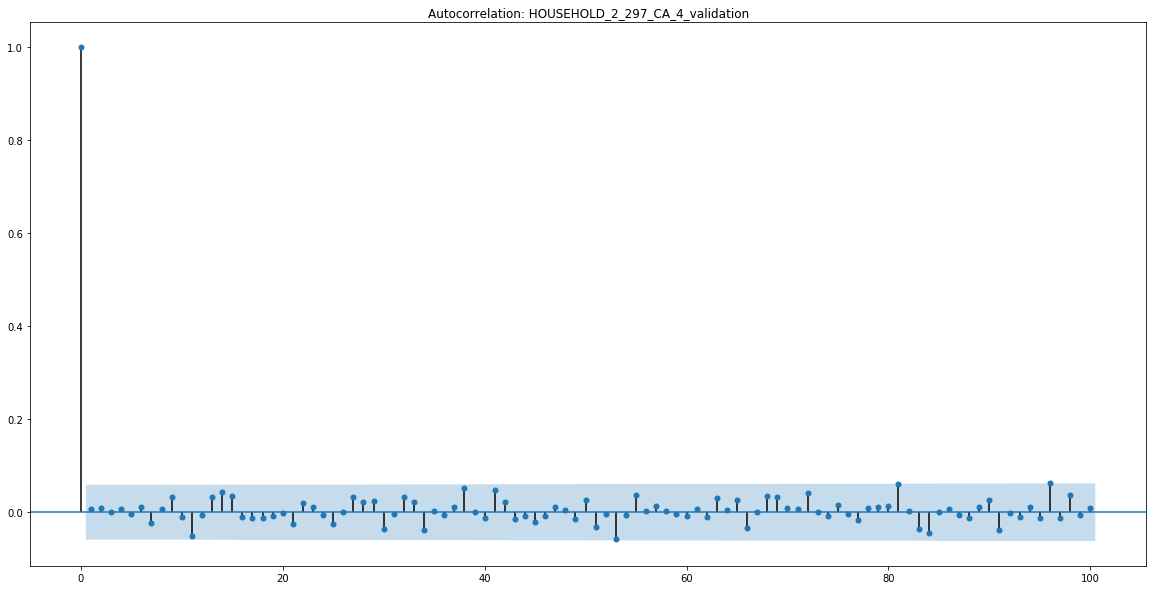

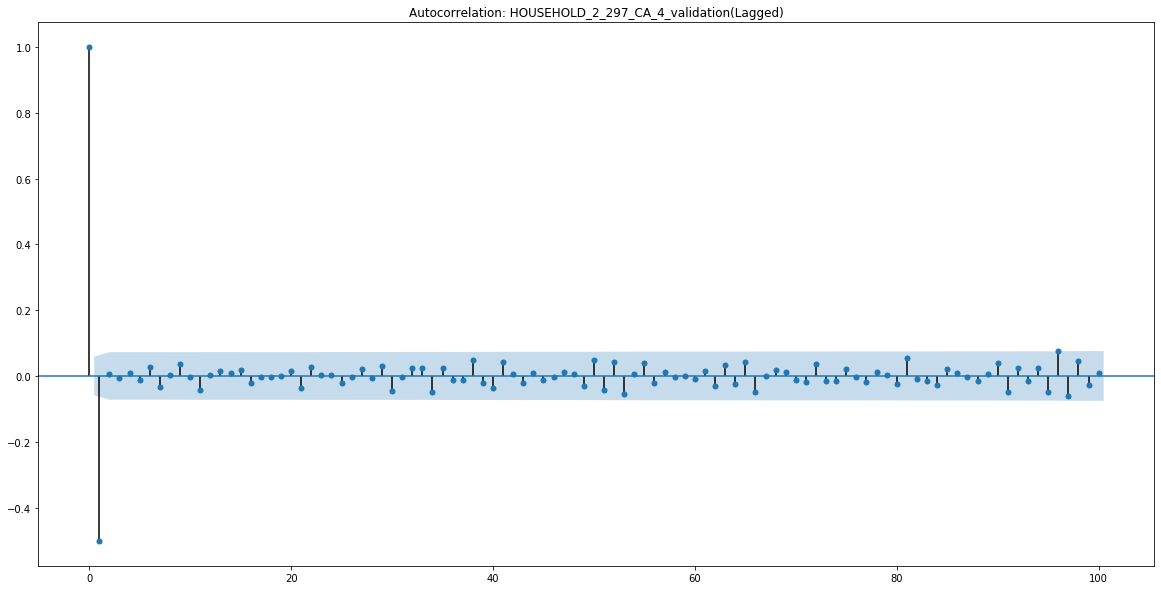

In [198]:
#HOUSEHOLD_2_033_CA_4_validation
pacf_acf(data_10539_train, 'HOUSEHOLD_2_297_CA_4_validation')

We can try to model an ARIMA(14, 1, 1).

Lets now see the correlation between the demand and the orher variables.

In [206]:
correlation_variables(data_10539_train)

demand                                  1.000000
SuperBowl_weekend                       0.048575
Sporting_weekend                        0.048286
IndependenceDay_week                    0.045878
ColumbusDay_near                        0.041214
                                          ...   
price_change_mean_t52_bin_-0.25-0.10         NaN
price_change_mean_t52_bin_-0.10-0.5          NaN
price_change_mean_t52_bin_-0.05-0            NaN
price_change_mean_t52_bin_0.10-0.25          NaN
price_change_mean_t52_bin_0.25++             NaN
Name: demand, Length: 238, dtype: float64

None of our variables are correlated with the demand.\
Therefore, lets try to model using the mode or ARIMA(14, 1, 1).

In [243]:
#Models for HOUSEHOLD_2_033_CA_4_validation
#Model 1: mode
RMSSE_mode_10539 = model_mode(data_10539_train)

#Model 2: ARIMA(20, 1, 1)
error_fit_2_10539, RMSSE_2_10539 = model_ARIMA(data_10539_train, 14, 1, 1)

Mode:
Forecast:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                 1884
Model:                ARIMA(14, 1, 1)   Log Likelihood               -1453.007
Method:                       css-mle   S.D. of innovations              0.523
Date:                Sat, 16 May 2020   AIC                           2938.014
Time:                        21:39:06   BIC                           3026.672
Sample:                             1   HQIC                          2970.666
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.D.demand     -0.0009      0.023     -0.039      0.969      -0.047       0.045
ar.L2.D.demand

In [244]:
#Verify RMSSE
print('RMSSE_mode_10539:', RMSSE_mode_10539)
print('RMSSE_2_10539:', RMSSE_2_10539)

RMSSE_mode_10539: 0.0204
RMSSE_2_10539: 0.0204


In [273]:
#Make holdout
holdout_mode('HOUSEHOLD_2_297_CA_4_validation', data_10539_train)

Lets study our next product:\
HOBBIES_2_066_TX_1_validation

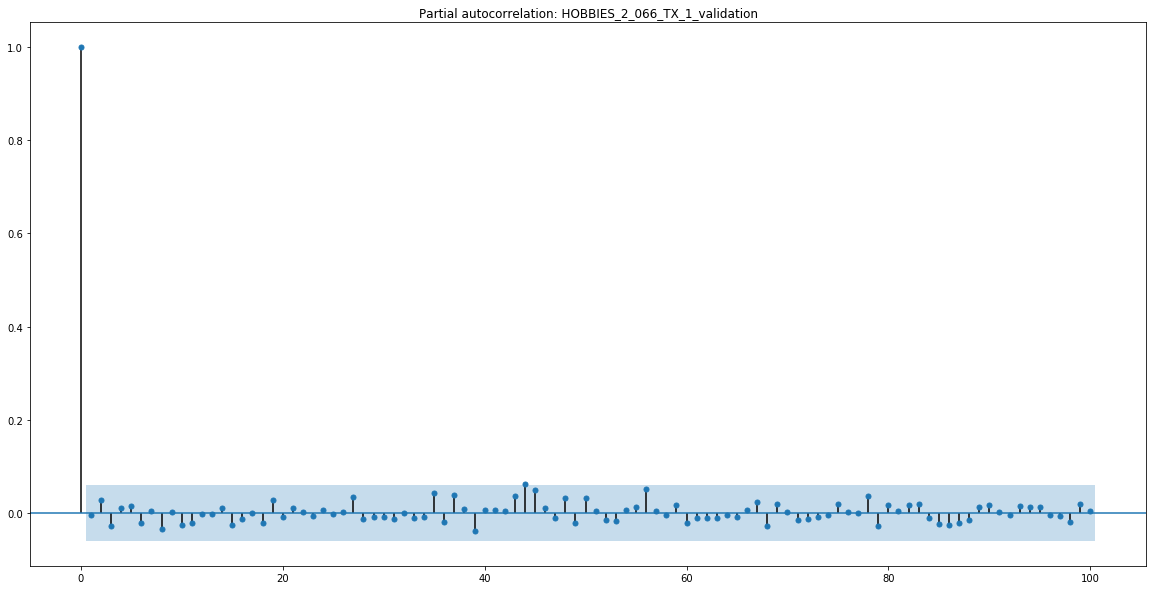

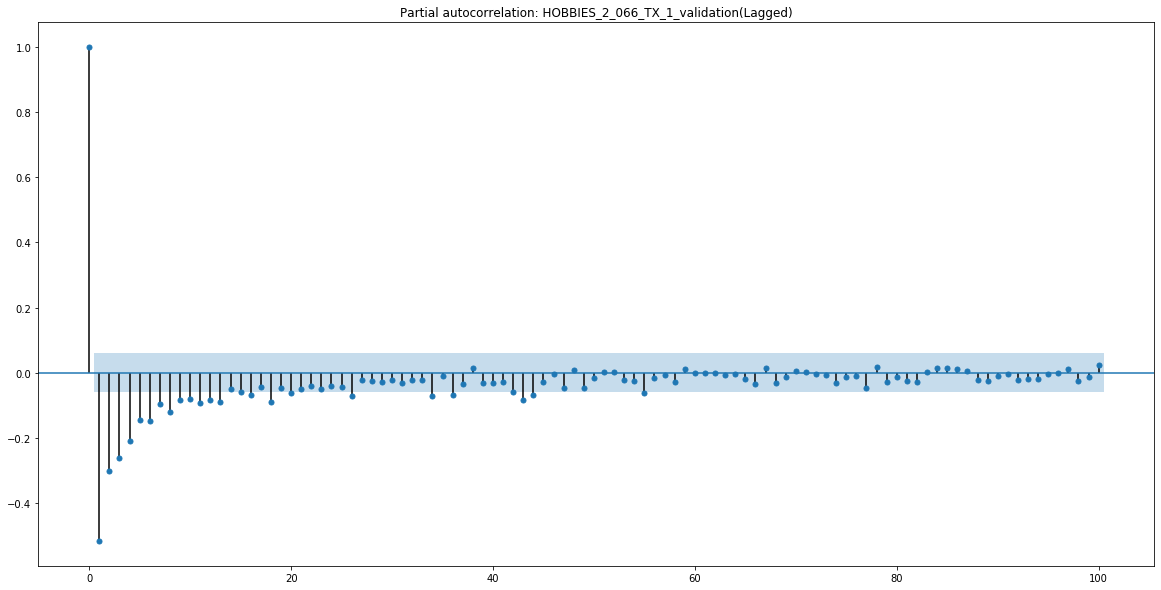

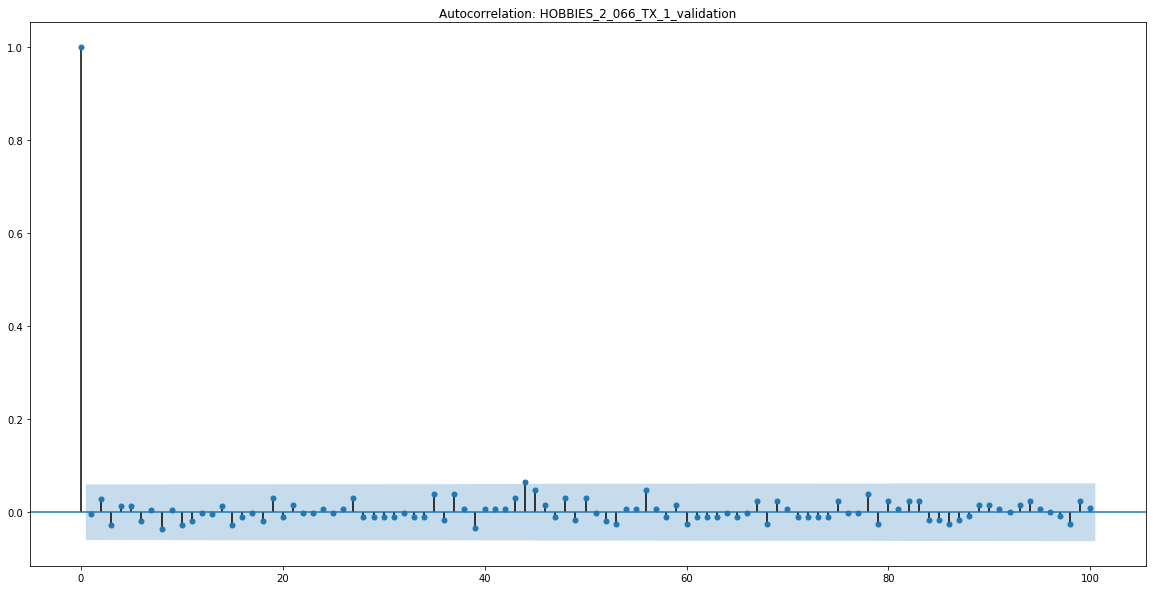

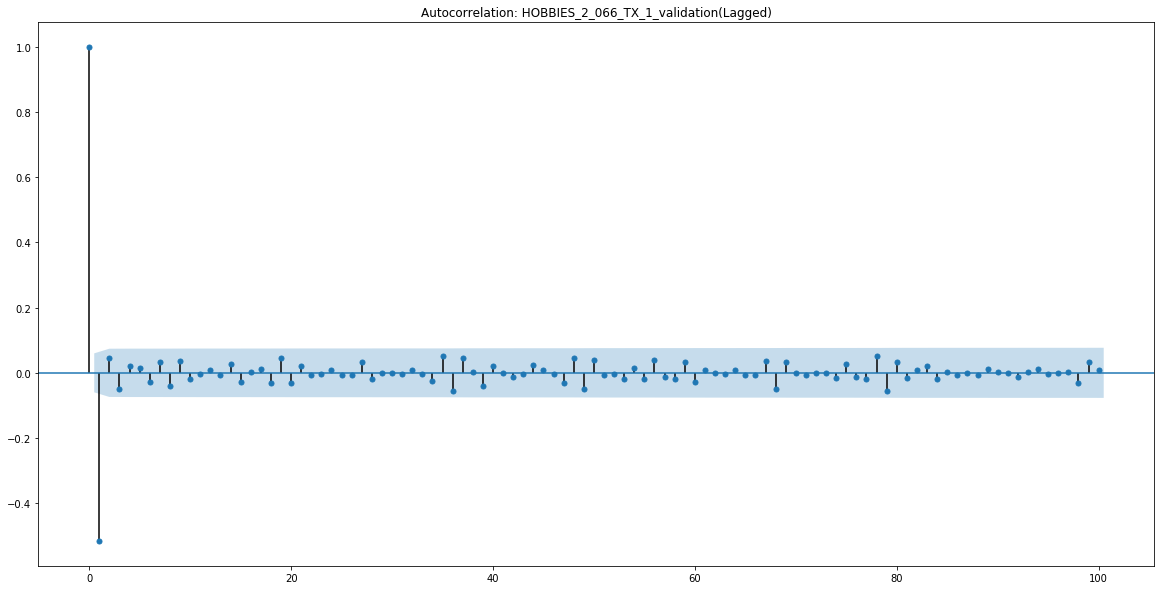

In [248]:
#HOUSEHOLD_2_033_CA_4_validation
pacf_acf(data_12677_train, 'HOBBIES_2_066_TX_1_validation')

We can try to model an ARIMA(13, 1, 1).

Lets now see the correlation between the demand and the orher variables.

In [249]:
correlation_variables(data_12677_train)

demand                                 1.000000
National_week                          0.047930
National_near                          0.045988
wday_4                                 0.041870
week_fase_3                            0.037265
                                         ...   
price_change_mean_t52_bin_-0.10-0.5         NaN
price_change_mean_t52_bin_-0.05-0           NaN
price_change_mean_t52_bin_0.05-0.10         NaN
price_change_mean_t52_bin_0.10-0.25         NaN
price_change_mean_t52_bin_0.25++            NaN
Name: demand, Length: 238, dtype: float64

None of our variables are correlated with the demand.\
Therefore, lets try to model using the mode or ARIMA(13, 1, 1).

In [250]:
#Models for HOBBIES_2_066_TX_1_validation
#Model 1: mode
RMSSE_mode_12677 = model_mode(data_12677_train)

#Model 2: ARIMA(20, 1, 1)
error_fit_2_12677, RMSSE_2_12677 = model_ARIMA(data_12677_train, 13, 1, 1)

Mode:
Forecast:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                 1828
Model:                ARIMA(13, 1, 1)   Log Likelihood                -100.670
Method:                       css-mle   S.D. of innovations              0.255
Date:                Sat, 16 May 2020   AIC                            231.340
Time:                        21:51:32   BIC                            314.005
Sample:                             1   HQIC                           261.831
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.D.demand     -0.0067      0.024     -0.284      0.776      -0.053       0.039
ar.L2.D.demand

In [251]:
#Verify RMSSE
print('RMSSE_mode_12677:', RMSSE_mode_12677)
print('RMSSE_2_12677:', RMSSE_2_12677)

RMSSE_mode_12677: 0.0211
RMSSE_2_12677: 0.0211


In [274]:
#Make holdout
holdout_mode('HOBBIES_2_066_TX_1_validation', data_12677_train)

Lets study our next product:\
HOUSEHOLD_1_422_TX_1_validation

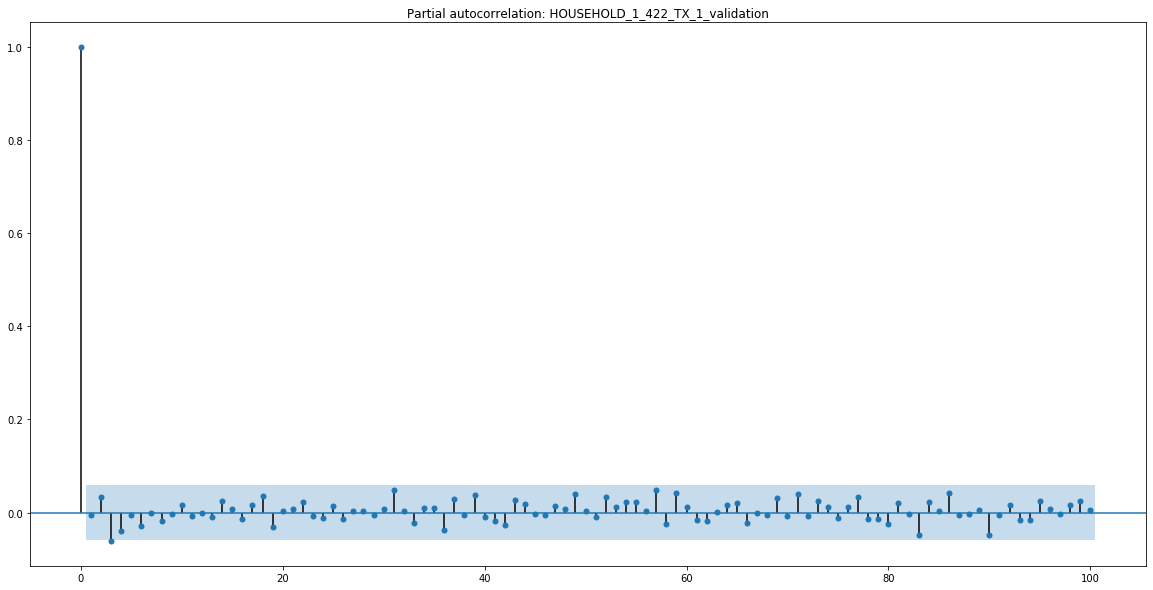

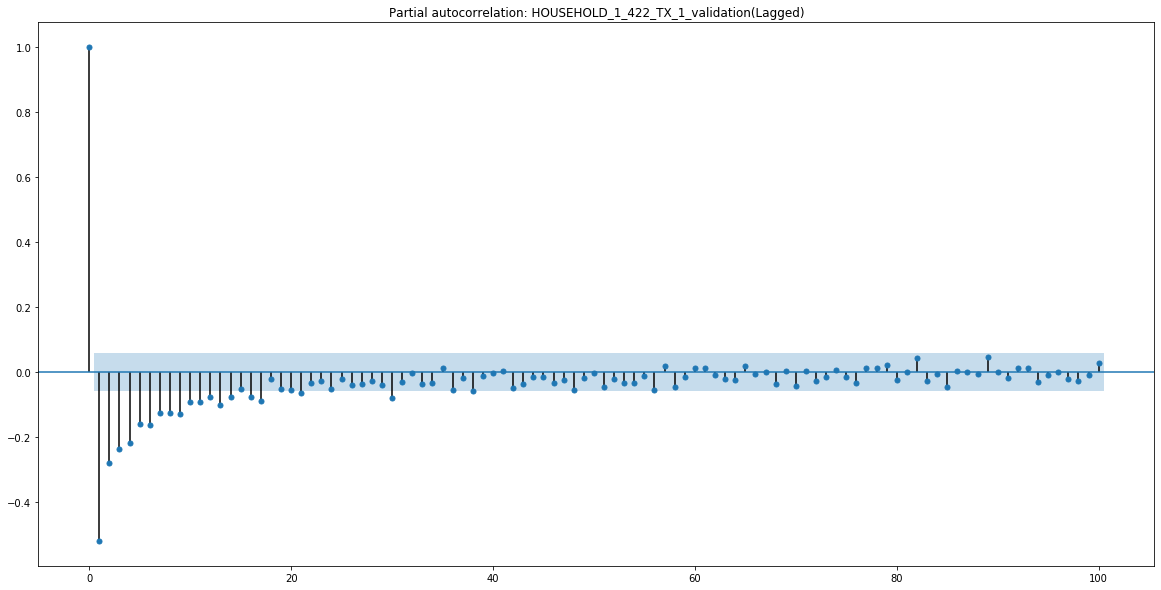

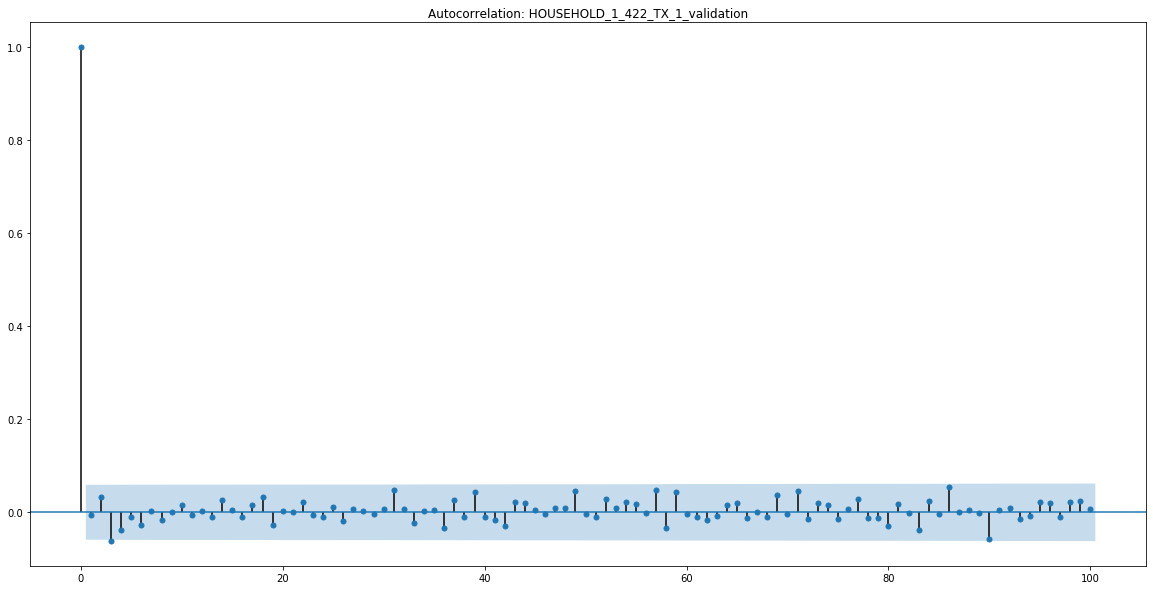

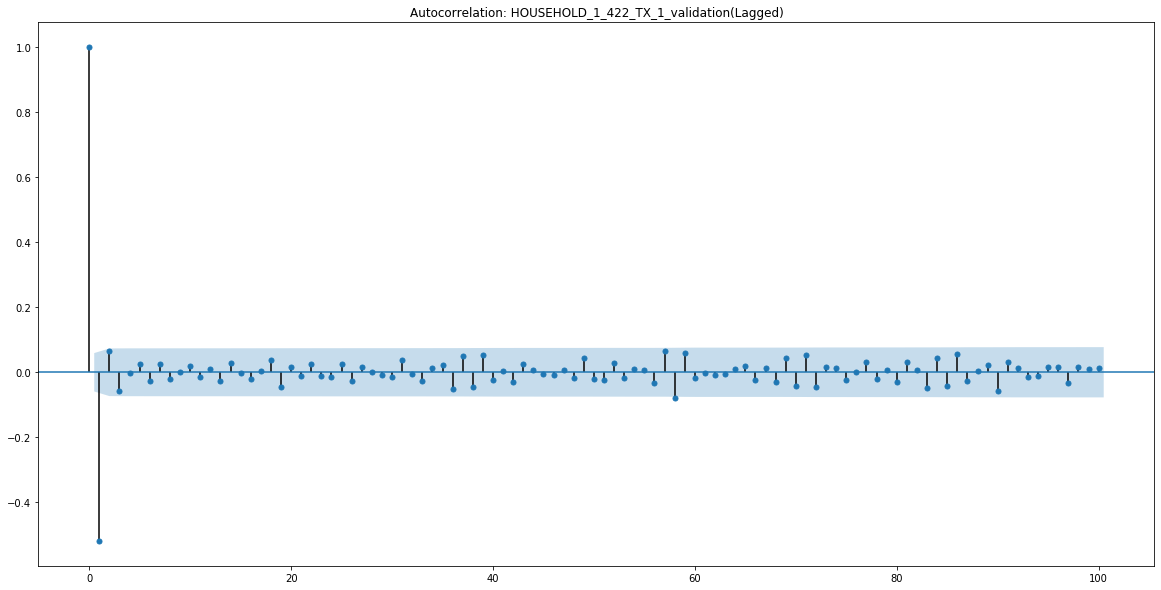

In [253]:
#HOUSEHOLD_1_422_TX_1_validation
pacf_acf(data_13173_train, 'HOUSEHOLD_1_422_TX_1_validation')

We can try to model an ARIMA(17, 1, 1).

Lets now see the correlation between the demand and the orher variables.

In [254]:
correlation_variables(data_13173_train)

demand                                  1.000000
price_change_mean_t52_bin_-0.05-0       0.048879
NBAFinalsEnd                            0.047587
Cinco De Mayo_near                      0.043709
demand_rolling_skew_t30                 0.043453
                                          ...   
price_change_mean_t52_bin_--0.25             NaN
price_change_mean_t52_bin_-0.25-0.10         NaN
price_change_mean_t52_bin_0.05-0.10          NaN
price_change_mean_t52_bin_0.10-0.25          NaN
price_change_mean_t52_bin_0.25++             NaN
Name: demand, Length: 238, dtype: float64

None of our variables are correlated with the demand.
Therefore, lets try to model using the mode or ARIMA(17, 1, 1).

In [255]:
#Models for HOUSEHOLD_1_422_TX_1_validation
#Model 1: mode
RMSSE_mode_13173 = model_mode(data_13173_train)

#Model 2: ARIMA(20, 1, 1)
error_fit_2_13173, RMSSE_2_13173 = model_ARIMA(data_13173_train, 17, 1, 1)

Mode:
Forecast:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                 1877
Model:                ARIMA(17, 1, 1)   Log Likelihood               -1887.349
Method:                       css-mle   S.D. of innovations              0.661
Date:                Sat, 16 May 2020   AIC                           3812.698
Time:                        21:53:50   BIC                           3917.909
Sample:                             1   HQIC                          3851.454
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.D.demand     -0.0124      0.023     -0.533      0.594      -0.058       0.033
ar.L2.D.demand

In [256]:
#Verify RMSSE
print('RMSSE_mode_13173:', RMSSE_mode_13173)
print('RMSSE_2_13173:', RMSSE_2_13173)

RMSSE_mode_13173: 0.0222
RMSSE_2_13173: 0.0222


In [275]:
#Make holdout
holdout_mode('HOUSEHOLD_1_422_TX_1_validation', data_13173_train)

Lets study our next product:\
HOBBIES_1_117_CA_4_validation

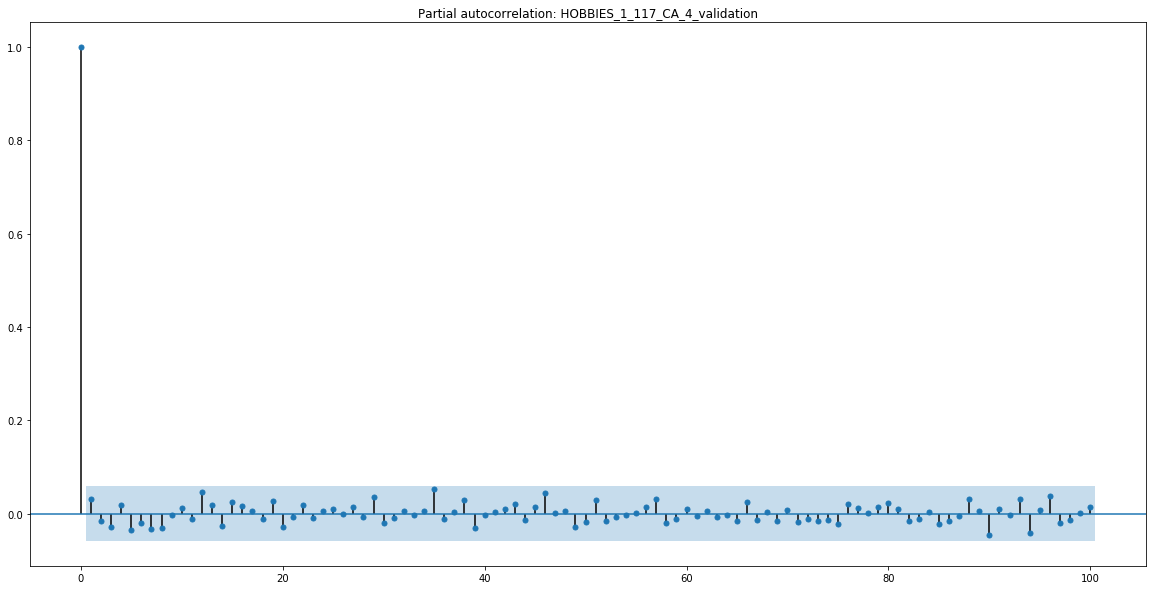

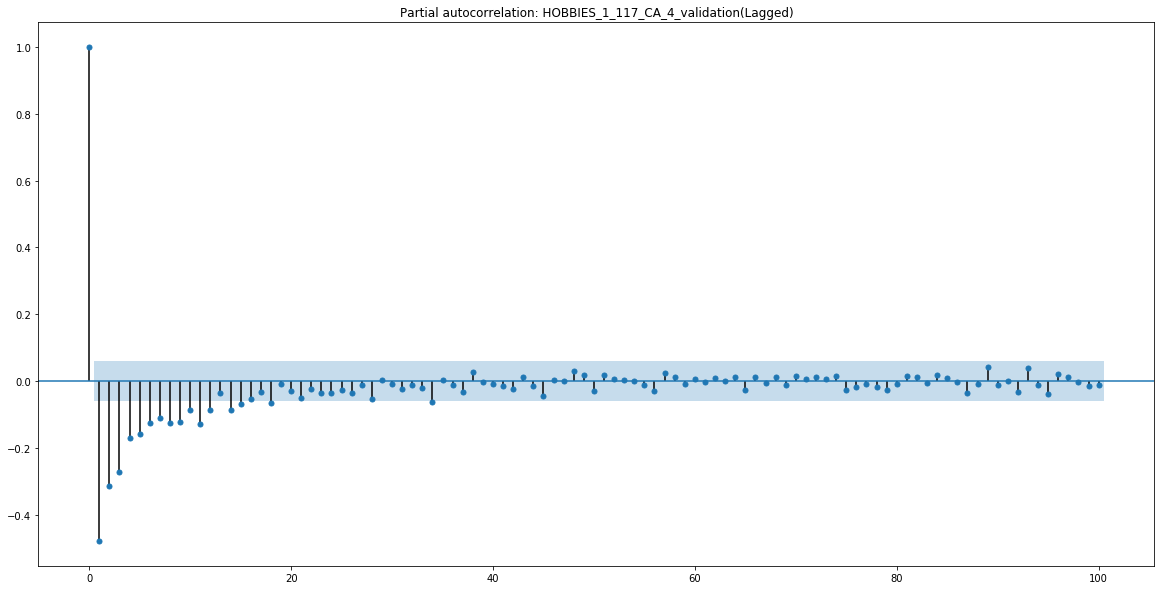

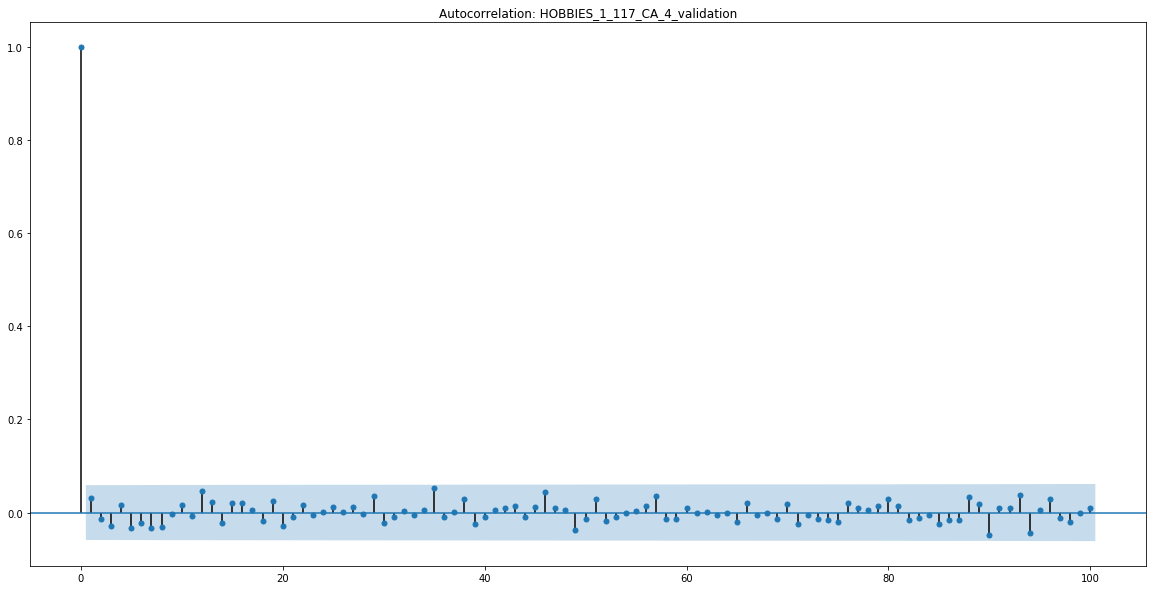

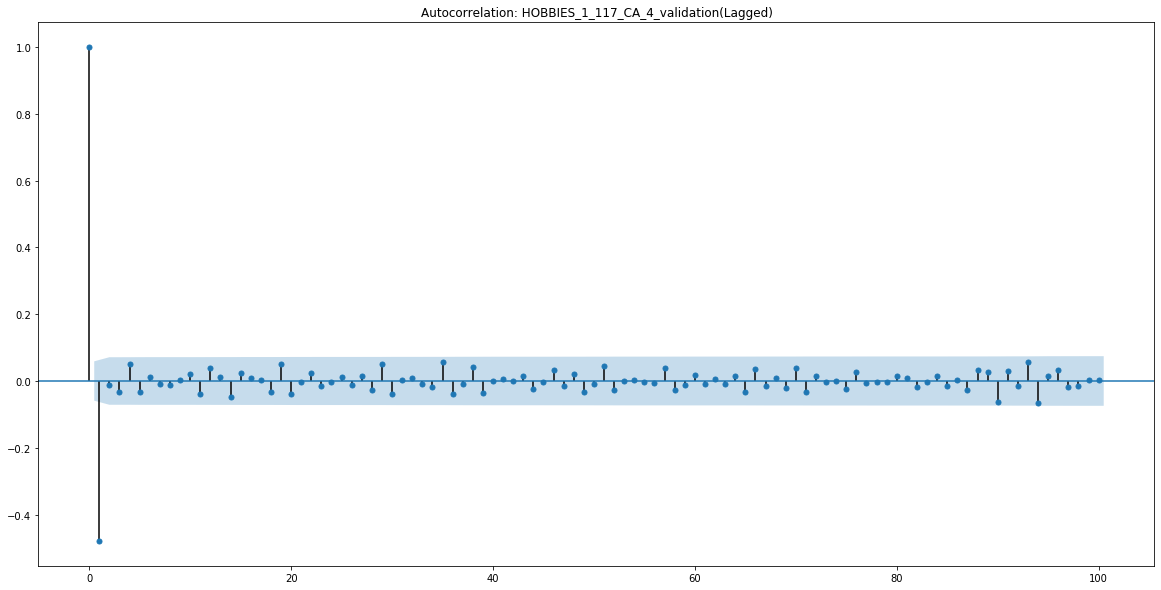

In [258]:
#HOBBIES_1_117_CA_4_validation
pacf_acf(data_9259_train, 'HOBBIES_1_117_CA_4_validation')

We can try to model an ARIMA(15, 1, 1).

Lets now see the correlation between the demand and the orher variables.

In [259]:
correlation_variables(data_9259_train)

demand                                  1.000000
National_weekend                        0.046215
Eid al-Fitr_near                        0.045239
National                                0.044041
Cinco De Mayo_weekend                   0.042140
                                          ...   
price_change_mean_t52_bin_-0.25-0.10         NaN
price_change_mean_t52_bin_-0.10-0.5          NaN
price_change_mean_t52_bin_-0.05-0            NaN
price_change_mean_t52_bin_0.10-0.25          NaN
price_change_mean_t52_bin_0.25++             NaN
Name: demand, Length: 238, dtype: float64

None of our variables are correlated with the demand.
Therefore, lets try to model using the mode or ARIMA(15, 1, 1).

In [260]:
#Models for HOBBIES_1_117_CA_4_validation
#Model 1: mode
RMSSE_mode_9259 = model_mode(data_9259_train)

#Model 2: ARIMA(20, 1, 1)
error_fit_2_9259, RMSSE_2_9259 = model_ARIMA(data_9259_train, 15, 1, 1)

Mode:
Forecast:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                             ARIMA Model Results                              
Dep. Variable:               D.demand   No. Observations:                 1884
Model:                ARIMA(15, 1, 1)   Log Likelihood                -798.313
Method:                       css-mle   S.D. of innovations              0.369
Date:                Sat, 16 May 2020   AIC                           1630.626
Time:                        21:56:11   BIC                           1724.826
Sample:                             1   HQIC                          1665.319
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.D.demand      0.0309      0.023      1.342      0.180      -0.014       0.076
ar.L2.D.demand

In [261]:
#Verify RMSSE
print('RMSSE_mode_9259:', RMSSE_mode_9259)
print('RMSSE_2_9259:', RMSSE_2_9259)

RMSSE_mode_9259: 0.0119
RMSSE_2_9259: 0.0119


In [276]:
#Make holdout
holdout_mode('HOBBIES_1_117_CA_4_validation', data_9259_train)